In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

import treecorr
import pyccl

from hydra import initialize, compose
from hydra.utils import instantiate

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

### Generate posterior samples of shear and convergence

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2.ckpt"

with initialize(config_path="../../../", version_base=None):
    cfg = compose("lensing_config_dc2", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

In [4]:
test_data = []
for batch in test_dl:
    test_data.append(move_data_to_device(batch, device))

In [5]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

In [6]:
num_samples = 1000

shear1_true = torch.zeros(len(test_data), 8, 8, device=device)
shear1_samples = torch.zeros(len(test_data), num_samples, 8, 8, device=device)
shear1_mode = torch.zeros(len(test_data), 8, 8, device=device)
shear2_true = torch.zeros(len(test_data), 8, 8, device=device)
shear2_samples = torch.zeros(len(test_data), num_samples, 8, 8, device=device)
shear2_mode = torch.zeros(len(test_data), 8, 8, device=device)
convergence_true = torch.zeros(len(test_data), 8, 8, device=device)
convergence_samples = torch.zeros(len(test_data), num_samples, 8, 8, device=device)
convergence_mode = torch.zeros(len(test_data), 8, 8, device=device)
ra = torch.zeros(len(test_data), 8, 8, device=device)
dec = torch.zeros(len(test_data), 8, 8, device=device)
redshift = torch.zeros(len(test_data), 8, 8, device=device)

for i in range(len(test_data)):
    shear1_true[i] = test_data[i]['tile_catalog']['shear_1'].squeeze()
    shear2_true[i] = test_data[i]['tile_catalog']['shear_2'].squeeze()
    convergence_true[i] = test_data[i]['tile_catalog']['convergence'].squeeze()
    ra[i] = test_data[i]['tile_catalog']['ra'].squeeze()
    dec[i] = test_data[i]['tile_catalog']['dec'].squeeze()
    redshift[i] = test_data[i]['tile_catalog']['redshift'].squeeze()
    
    with torch.no_grad():
        input_lst = [inorm.get_input_tensor(test_data[i]) for inorm in encoder.image_normalizers]
        inputs = torch.cat(input_lst, dim=2)
        x_features = encoder.features_net(inputs)
        x_cat_marginal = encoder.catalog_net(x_features)
        
        for n in range(num_samples):            
            sample = encoder.var_dist.sample(x_cat_marginal, use_mode=False, return_base_cat=True)
            mode = encoder.var_dist.sample(x_cat_marginal, use_mode=True, return_base_cat=True)
            shear1_samples[i,n] = sample['shear_1'].squeeze()
            shear1_mode[i] = mode['shear_1'].squeeze()
            shear2_samples[i,n] = sample['shear_2'].squeeze()
            shear2_mode[i] = mode['shear_2'].squeeze()
            convergence_samples[i,n] = sample['convergence'].squeeze()
            convergence_mode[i] = mode['convergence'].squeeze()

### Compute two-point correlation function (2PCF) for each sample

In [7]:
min_sep = 1
max_sep = 80
sep_units = "arcmin"

bin_type = 'Linear'
nbins = 10

xip = torch.zeros(num_samples, nbins, device = device)
xim = torch.zeros(num_samples, nbins, device = device)

In [8]:
for n in range(num_samples):
    if n % 100 == 0:
        print(n)
    treecorr_catalog = treecorr.Catalog(ra = ra.flatten().cpu(), ra_units = "deg",
                                        dec = dec.flatten().cpu(), dec_units = "deg",
                                        g1 = shear1_samples[:,n,...].flatten().cpu(),
                                        g2 = shear2_samples[:,n,...].flatten().cpu(),
                                        k = convergence_samples[:,n,...].flatten().cpu())
    
    gg = treecorr.GGCorrelation(min_sep = min_sep, max_sep = max_sep, sep_units = sep_units,
                                bin_type = bin_type, nbins = nbins)
    gg.process(treecorr_catalog)
    
    xip[n] = torch.from_numpy(gg.xip.copy()).to(device)
    xim[n] = torch.from_numpy(gg.xim.copy()).to(device)

0
100
200
300
400
500
600
700
800
900


### Plot 2PCFs

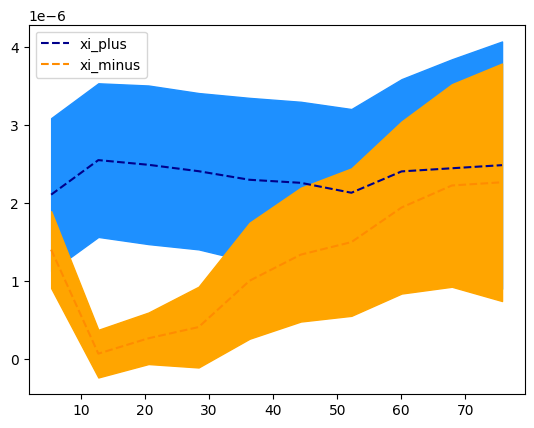

In [9]:
r = np.exp(gg.meanlogr)

_ = plt.plot(r, xip.mean(0).cpu(), color = 'darkblue', linestyle = '--', label = 'xi_plus')
_ = plt.fill_between(r, xip.mean(0).cpu() - 1.96*xip.std(0).cpu(), xip.mean(0).cpu() + 1.96*xip.std(0).cpu(), color = 'dodgerblue')
_ = plt.plot(r, xim.mean(0).cpu(), color = 'darkorange', linestyle = '--', label = 'xi_minus')
_ = plt.fill_between(r, xim.mean(0).cpu() - 1.96*xim.std(0).cpu(), xim.mean(0).cpu() + 1.96*xim.std(0).cpu(), color = 'orange')
_ = plt.legend()

### Theoretical 2PCFs using `pyccl`

In [10]:
wmap7_cosmo = pyccl.cosmology.Cosmology(Omega_c = 0.22,
                                        Omega_b = 0.048,
                                        h = 0.71,
                                        n_s = 0.963,
                                        sigma8 = 0.8)

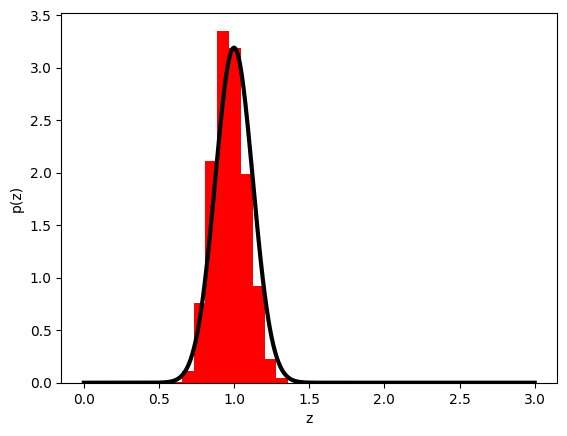

In [11]:
z = np.linspace(0.001, 3, 512)
n = norm.pdf(z, 1.0, 0.125)

_ = plt.hist(redshift.flatten().cpu(), bins = 10, density = True, color = 'red')
_ = plt.plot(z, n, color = 'black', linewidth = 3)
_ = plt.xlabel('z')
_ = plt.ylabel('p(z)')

In [12]:
lensing_tracer = pyccl.WeakLensingTracer(wmap7_cosmo, dndz=(z, n))

ell = np.arange(10, 2000)
cl = pyccl.angular_cl(wmap7_cosmo, lensing_tracer, lensing_tracer, ell)

In [13]:
theta_degrees = r/60  # 1 degree is 60 arcmins

xip_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG+')
xim_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG-')

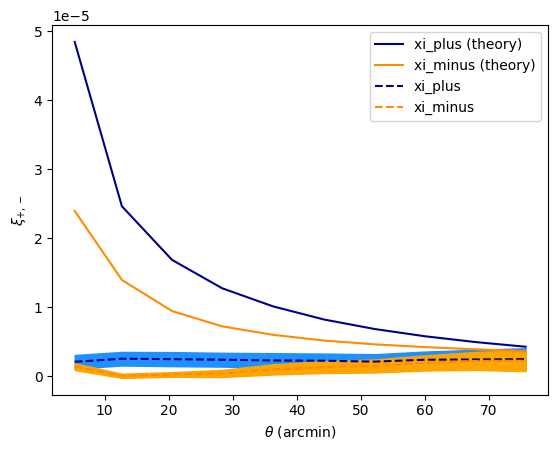

In [20]:
_ = plt.plot(r, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(r, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.plot(r, xip.mean(0).cpu(), color = 'darkblue', linestyle = '--', label = 'xi_plus')
_ = plt.fill_between(r, xip.mean(0).cpu() - 1.96*xip.std(0).cpu(), xip.mean(0).cpu() + 1.96*xip.std(0).cpu(), color = 'dodgerblue')
_ = plt.plot(r, xim.mean(0).cpu(), color = 'darkorange', linestyle = '--', label = 'xi_minus')
_ = plt.fill_between(r, xim.mean(0).cpu() - 1.96*xim.std(0).cpu(), xim.mean(0).cpu() + 1.96*xim.std(0).cpu(), color = 'orange')
_ = plt.legend()

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')